In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
#from utils.metrics import log_rank, cox_estimation

In [2]:
n_samples = 600
n_features_bytype = 4
n_features_multiplier = 3 

In [3]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [4]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples)
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [5]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.232115,-0.005418,0.617265,0.293210,1.663366,0.326065,1.029122,1.653213,1.0,0.0,0.0,1.0,2.138367,0
1,2.391064,2.270207,1.321483,-0.223459,0.162198,0.503271,0.039587,0.496924,0.0,1.0,1.0,0.0,0.782468,0
2,1.218877,0.138211,-0.052931,-1.456686,2.849174,0.695739,0.257567,0.262227,0.0,0.0,0.0,0.0,0.309854,0
4,-0.057679,0.151849,-1.451763,-2.054206,1.770322,0.374070,1.250062,0.809636,1.0,0.0,0.0,1.0,1.046072,0
5,1.133604,-0.085758,-0.849618,-1.027719,0.016576,0.863162,0.208538,0.871970,1.0,0.0,0.0,0.0,0.430952,0


In [6]:
types

,name,type,dim,nclass
0,feat1,real,1,
1,feat2,real,1,
2,feat3,real,1,
3,feat4,real,1,
4,feat5,pos,1,
5,feat6,pos,1,
6,feat7,pos,1,
7,feat8,pos,1,
8,feat9,cat,1,2
9,feat10,cat,1,2


In [7]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [8]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

In [9]:
data = pd.concat([control,treated],ignore_index=True)
T = data['time']
C = data['censor']
D = np.sum(T <= C)

In [10]:
alpha = 0.05
p_treated = 0.5
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha))

In [11]:
expected_power

0.05000000000000007

## Generation

In [12]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                         miss_file, true_miss_file)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [13]:
data_init_control_encoded

tensor([[ 0.2321, -0.0054,  0.6173,  ...,  1.0000,  2.1384,  0.0000],
        [ 2.3911,  2.2702,  1.3215,  ...,  0.0000,  0.7825,  0.0000],
        [ 1.2189,  0.1382, -0.0529,  ...,  0.0000,  0.3099,  0.0000],
        ...,
        [-1.0994,  0.0602, -0.3654,  ...,  1.0000,  0.2950,  0.0000],
        [-1.3183,  0.2788, -1.0419,  ...,  0.0000,  0.4198,  1.0000],
        [-0.6283, -0.8155,  0.1641,  ...,  0.0000,  1.2354,  1.0000]])

In [14]:
fnames = types['name'][:-1].tolist()
fnames.append("time")#.append("censor")
fnames.append("censor")

In [15]:
feat_types_dict

[{'': '0', 'name': 'feat1', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '1', 'name': 'feat2', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '2', 'name': 'feat3', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '3', 'name': 'feat4', 'type': 'real', 'dim': '1', 'nclass': ''},
 {'': '4', 'name': 'feat5', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '5', 'name': 'feat6', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '6', 'name': 'feat7', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '7', 'name': 'feat8', 'type': 'pos', 'dim': '1', 'nclass': ''},
 {'': '8', 'name': 'feat9', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '9', 'name': 'feat10', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '10', 'name': 'feat11', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '11', 'name': 'feat12', 'type': 'cat', 'dim': '1', 'nclass': '2'},
 {'': '12',
  'name': 'survcens',
  'type': 'surv_weibull',
  'dim': '2',
  'nclass': ''}]

In [16]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

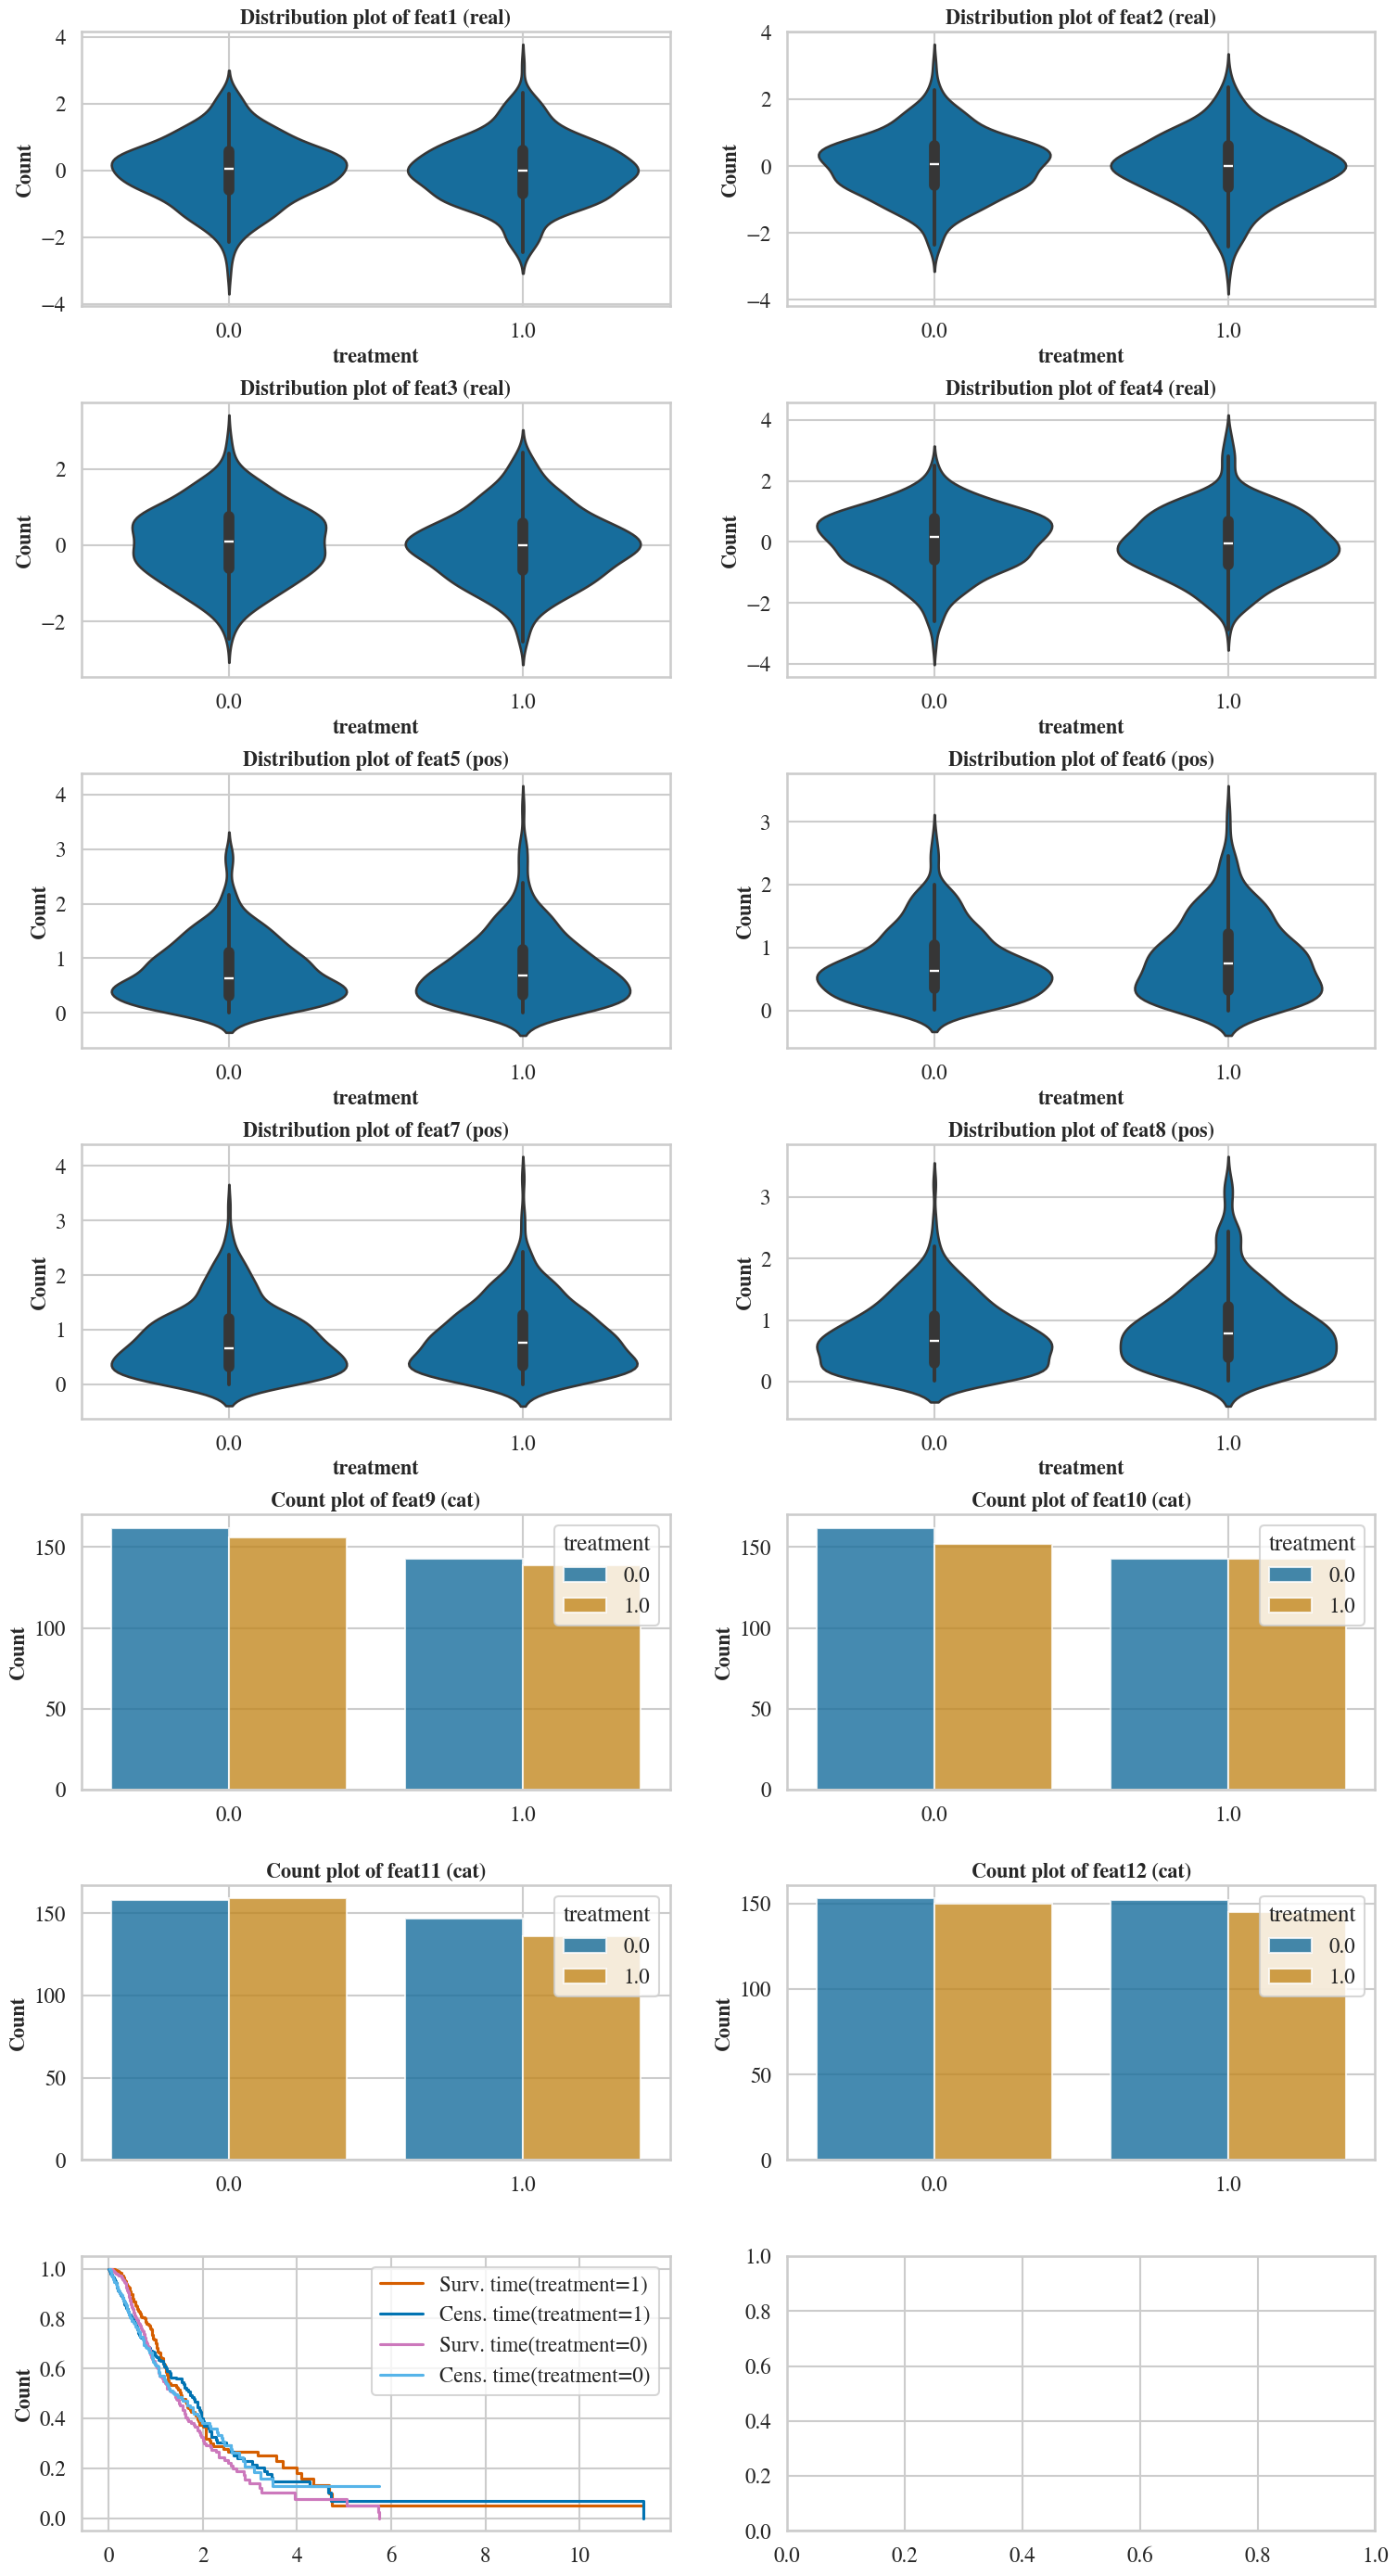

In [17]:
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [18]:
names_cont = []
names_pos = []
names_cat = []
for x in range(1, n_features_bytype   + 1):
            names_pos.append("feat{0}".format(x + n_features_bytype))
            names_cat.append("feat{0}".format(x + 2 * n_features_bytype))

table1 = TableOne(df_init, categorical=names_cat, continuous=names_cont, 
                  groupby='treatment', nonnormal=names_pos, pval=True)
print(table1)

                          Grouped by treatment                                                     
                                       Missing        Overall              0              1 P-Value
n                                                         600            305            295        
feat1, mean (SD)                             0     -0.0 (1.0)      0.0 (1.0)     -0.0 (1.0)   0.910
feat2, mean (SD)                             0     -0.0 (1.0)      0.0 (0.9)     -0.0 (1.0)   0.360
feat3, mean (SD)                             0      0.0 (0.9)      0.1 (0.9)     -0.0 (0.9)   0.405
feat4, mean (SD)                             0      0.0 (1.0)      0.0 (1.0)     -0.0 (1.1)   0.303
feat5, median [Q1,Q3]                        0  0.7 [0.3,1.1]  0.6 [0.3,1.1]  0.7 [0.3,1.2]   0.540
feat6, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.6 [0.3,1.0]  0.7 [0.3,1.2]   0.144
feat7, median [Q1,Q3]                        0  0.7 [0.3,1.2]  0.7 [0.3,1.2]  0.8 [0.3,1.3]   0.267


In [19]:
from execute import surv_hivae

# the datasets used for training is data_init_control
n_generated_sample = 10
T_surv = torch.Tensor(df_init_control.time)
T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
n_intervals = 5
T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]

In [20]:
data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample)

Epoch: [ 0]  time: 0.0328, ELBO_train: -14.53649282, KL_z: 2.23212206, KL_s: 0.10948265, reconstruction loss: -12.19488811
Epoch: [100]  time: 1.5488, ELBO_train: -11.52831316, KL_z: 0.86207458, KL_s: 0.04577792, reconstruction loss: -10.62046066
Epoch: [200]  time: 3.0629, ELBO_train: -11.43819332, KL_z: 1.09890074, KL_s: 0.03993273, reconstruction loss: -10.29935986
Epoch: [300]  time: 4.5798, ELBO_train: -11.33456707, KL_z: 1.25081056, KL_s: 0.03871262, reconstruction loss: -10.04504389
Epoch: [400]  time: 6.1168, ELBO_train: -11.44404221, KL_z: 1.40022665, KL_s: 0.04003894, reconstruction loss: -10.00377661
Training finished.


In [21]:
data_gen_control[1]

tensor([[ 0.3917, -0.5928, -0.0828,  ...,  0.0000,  0.2950,  1.0000],
        [ 2.0986,  0.4031,  0.2463,  ...,  0.0000,  1.1914,  1.0000],
        [-1.2109, -0.4743, -0.9413,  ...,  0.0000,  0.3687,  0.0000],
        ...,
        [-0.3678,  1.4014,  1.0924,  ...,  0.0000,  2.2892,  1.0000],
        [ 1.1699,  0.3823,  0.2638,  ...,  1.0000,  0.9523,  1.0000],
        [ 0.2306, -0.1555,  0.3397,  ...,  0.0000,  0.6694,  1.0000]])

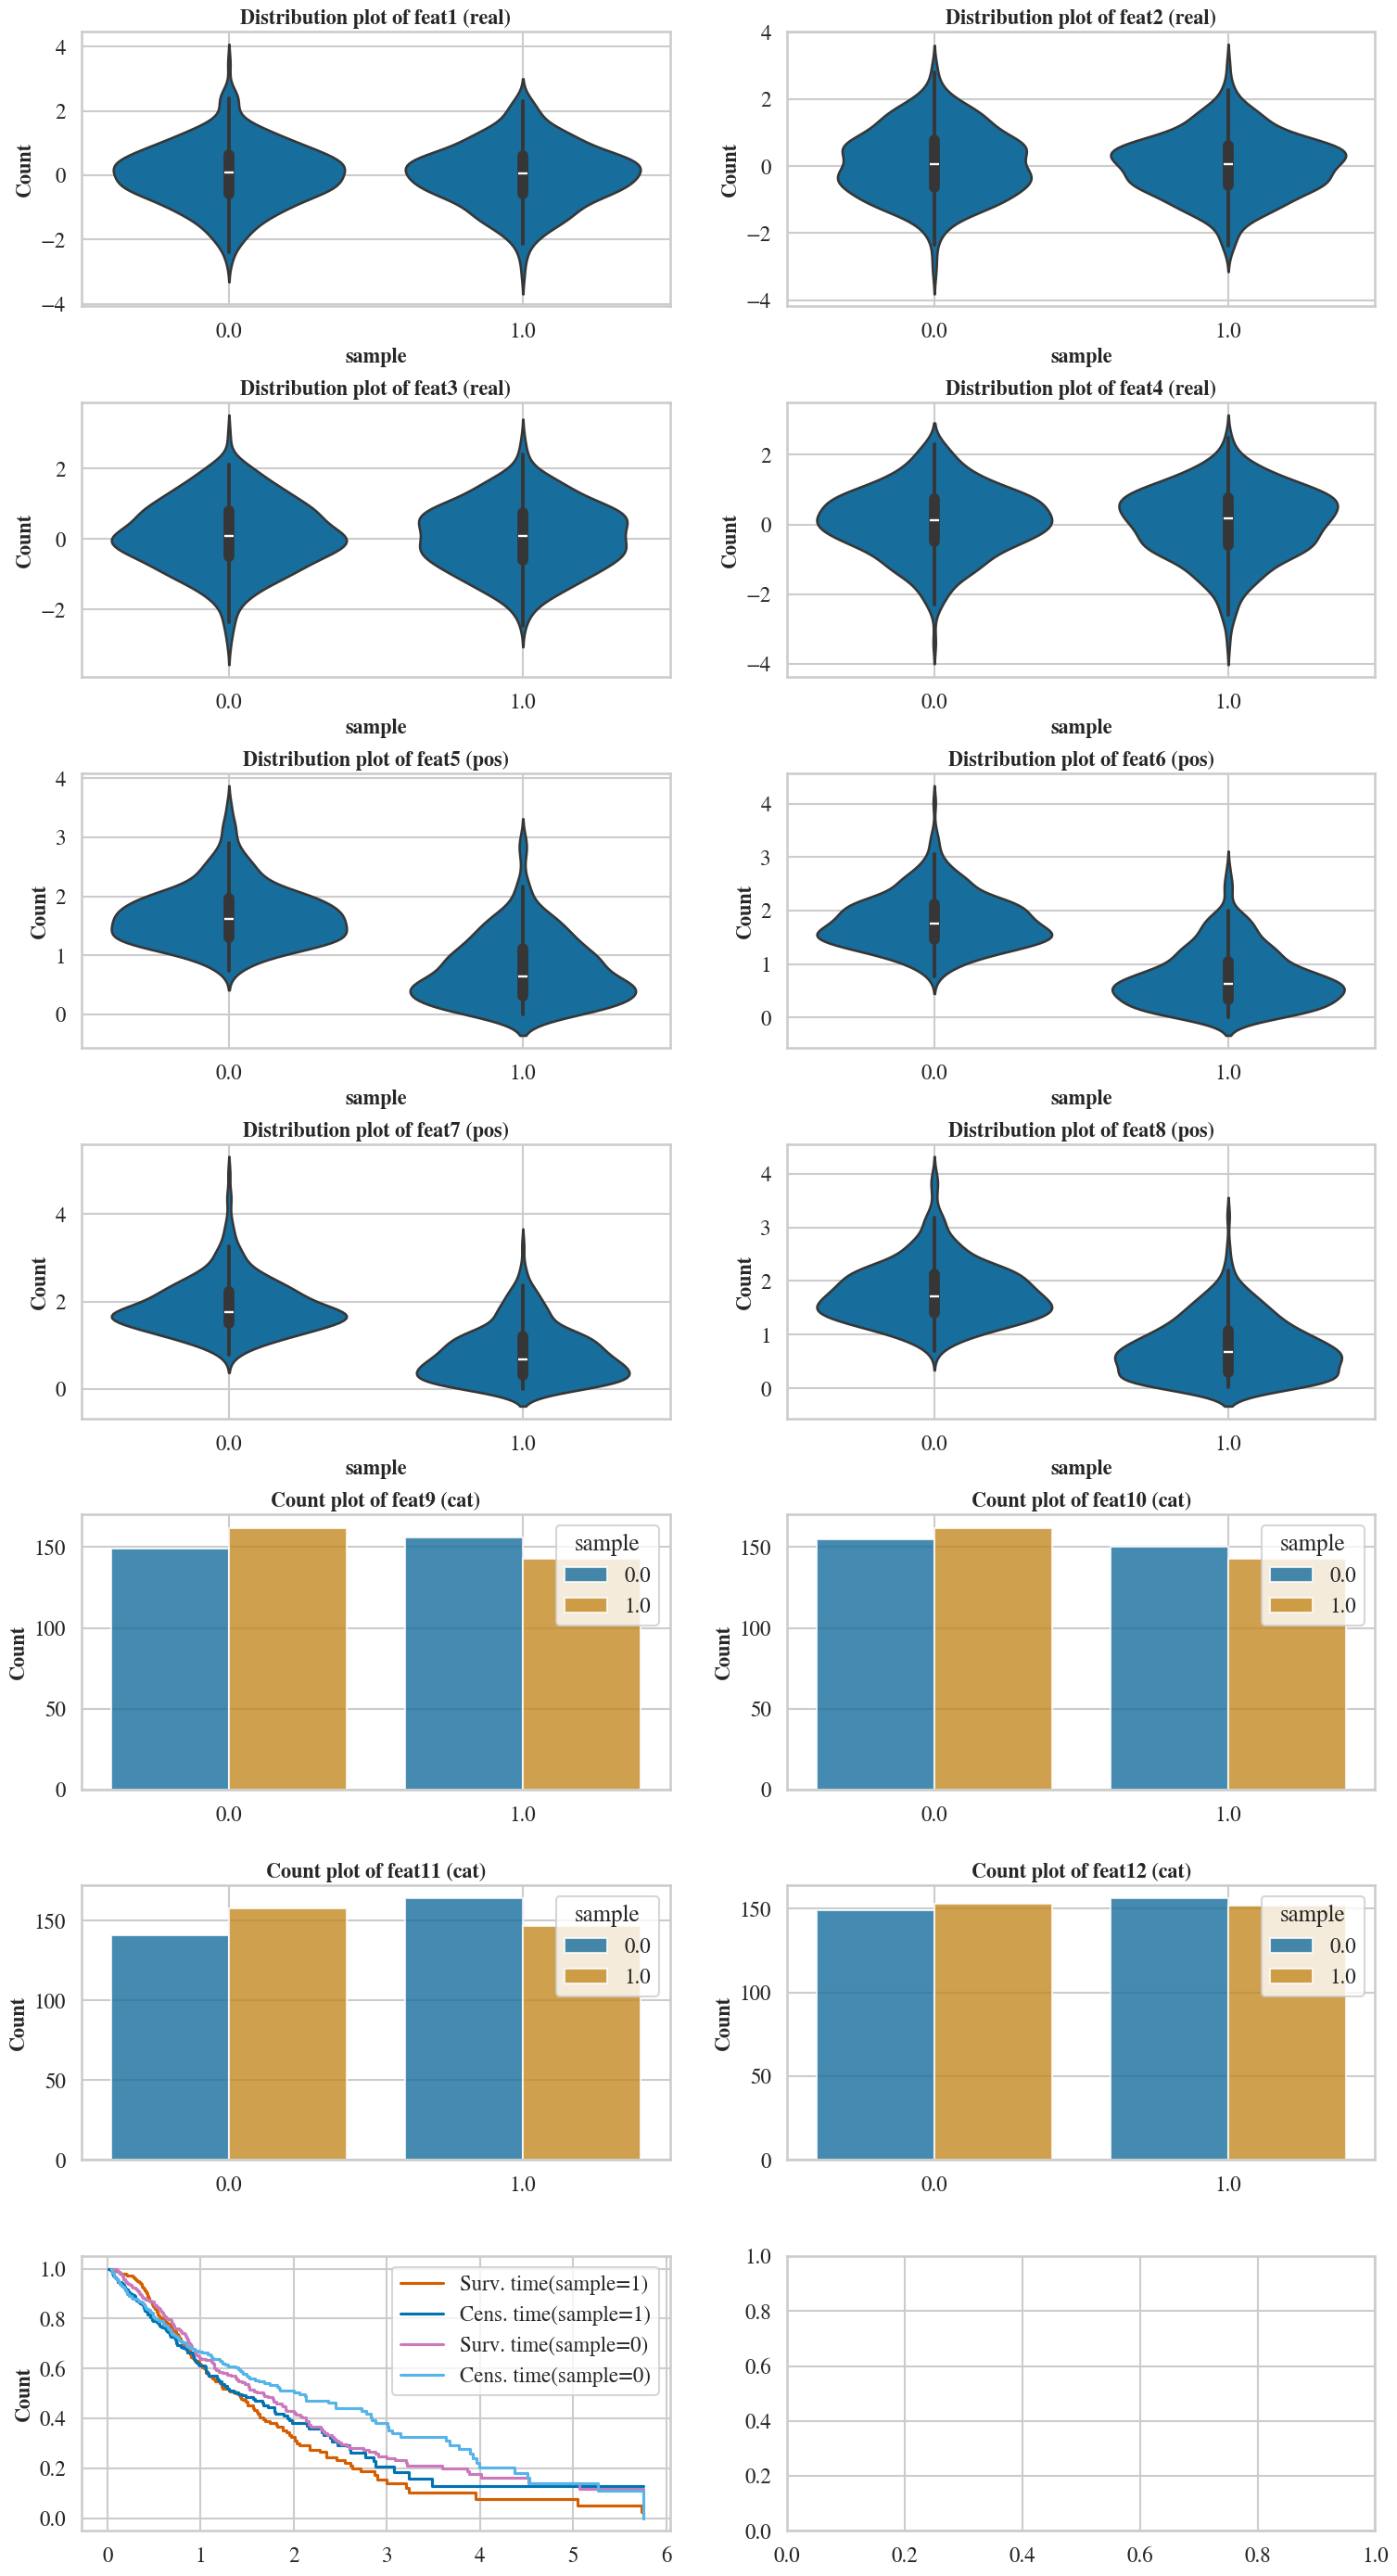

In [22]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=fnames)
df_init_control_ext['sample'] = 1

sel_idx = 0
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=fnames)
df_gen_control_ext_sel['sample'] = 0

# Save original values before overwriting
#tmp = df_gen_control_ext_sel[['time', 'censor']].copy()

# Replace 'time' with row-wise minimum
#df_gen_control_ext_sel['time'] = tmp.min(axis=1)

# Replace 'censor' with column name of the minimum ('time' or 'censor')
#df_gen_control_ext_sel['censor'] = 1* (tmp.idxmin(axis=1)=='time')
#df_gen_control_ext_sel[]

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [23]:
df_gen_control_ext_sel

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,time,censor,sample
0,1.118137,-1.008074,-1.352654,-0.186302,1.753426,1.430893,3.454612,2.247630,1.0,0.0,0.0,0.0,2.365975,0.0,0
1,0.994878,-0.214595,0.268206,0.412472,1.654075,1.420725,1.329042,1.592312,0.0,1.0,0.0,0.0,0.166676,1.0,0
2,-0.676278,-0.479024,-0.484221,-1.058433,1.338177,1.498274,1.175812,1.448287,1.0,0.0,1.0,0.0,0.326300,0.0,0
3,0.363338,-0.628249,-0.870205,-1.258279,1.898715,1.544632,1.906249,1.358365,0.0,0.0,0.0,0.0,0.405986,0.0,0
4,0.557193,-0.242560,-0.001780,-0.052788,1.461061,0.982791,2.579036,2.083764,0.0,1.0,1.0,0.0,0.643359,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,-0.203876,0.305991,0.250814,-0.701062,1.603970,2.061177,0.975475,1.228438,0.0,0.0,0.0,1.0,1.684039,0.0,0
301,-0.641737,-0.948465,0.348851,0.123134,1.807496,1.062725,1.024997,2.324882,1.0,1.0,1.0,1.0,0.766872,1.0,0
302,0.876023,-0.050552,1.450992,0.958595,0.866157,1.500512,2.008910,1.849377,0.0,0.0,0.0,0.0,4.517750,1.0,0
303,-0.291926,-0.168403,-0.501438,0.155879,1.192862,2.055250,1.907251,3.145900,0.0,1.0,1.0,1.0,0.437681,1.0,0


In [24]:
df_init_control_ext

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,time,censor,sample
0,0.232115,-0.005418,0.617265,0.293210,1.663366,0.326065,1.029122,1.653213,1.0,0.0,0.0,1.0,2.138367,0.0,1
1,2.391064,2.270206,1.321483,-0.223459,0.162198,0.503271,0.039587,0.496924,0.0,1.0,1.0,0.0,0.782468,0.0,1
2,1.218877,0.138211,-0.052931,-1.456686,2.849174,0.695739,0.257567,0.262227,0.0,0.0,0.0,0.0,0.309854,0.0,1
3,-0.057679,0.151849,-1.451763,-2.054205,1.770322,0.374070,1.250062,0.809636,1.0,0.0,0.0,1.0,1.046072,0.0,1
4,1.133604,-0.085758,-0.849618,-1.027719,0.016576,0.863162,0.208538,0.871970,1.0,0.0,0.0,0.0,0.430952,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,-1.435795,-2.118925,-1.693247,-1.116545,0.800696,0.224585,0.822262,0.535233,0.0,1.0,1.0,0.0,0.897447,1.0,1
301,-0.419684,-0.250189,0.331401,0.642038,1.437196,0.705596,2.065962,0.507764,0.0,1.0,1.0,1.0,3.208819,1.0,1
302,-1.099414,0.060221,-0.365448,1.561889,0.451228,0.456815,0.416131,0.648513,1.0,1.0,1.0,1.0,0.295004,0.0,1
303,-1.318286,0.278845,-1.041861,-0.238151,1.134118,0.346216,0.556552,1.553769,0.0,0.0,0.0,0.0,0.419846,1.0,1


## Replication

In [25]:
n_generated_sample = 20


#### TODO RECOPIER CE QUI PRECEDE

In [27]:
M = 100
log_p_value = []
log_p_value_gen = []
for m in np.arange(M):
    control, treated = simulation(beta_features, treatment_effect , n_samples, data_types_create=False)

    
    data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
    data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"

    
    control.to_csv(data_file_control,index=False , header=False)

    treated.to_csv(data_file_treated,index=False , header=False)


    p_value_init = compute_logrank_test(control, treated)
    dataset_name = "Simulations"

    data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)
    data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)



    # Load and transform control data

    data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                  true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_sample)

    
    for i in range(n_generated_sample):
        df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
        df_gen_control['treatment'] = 0
        log_p_value.append(p_value_init)
        p_value_gen = compute_logrank_test(df_gen_control, treated)
        log_p_value_gen.append(p_value_gen)
    

    #LR_init, LR_syn = log_rank(df_init, data_syn)
#

ValueError: Expected parameter loc (Tensor of shape (32, 1)) of distribution Normal(loc: torch.Size([32, 1]), scale: torch.Size([32, 1])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan]])

In [23]:
data

0.0

In [25]:
log_p_value_gen

[123.37976071874311]

In [26]:
log_p_value

[1.5855680219584005]